In [4]:
#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [13]:
#Get the Stock Quote: The price of a stock as quoted on an exchange
df = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') #end = '2017-12-31', format = 'YYYY-MM-DD'
#Show the data
df.head(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.994907
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.268970
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.838169
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.380054
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.296970
2012-01-10,60.857143,60.214287,60.844284,60.462856,64549100.0,52.484222
2012-01-11,60.407143,59.901428,60.382858,60.364285,53771200.0,52.398655
2012-01-12,60.414288,59.821430,60.325714,60.198570,53146800.0,52.254814
2012-01-13,60.064285,59.808571,59.957142,59.972858,56505400.0,52.058880


In [14]:
#Show the number of rows and columns in the data
#The data frame has 2004 rows of data and 6 columns
df.shape

(2003, 6)

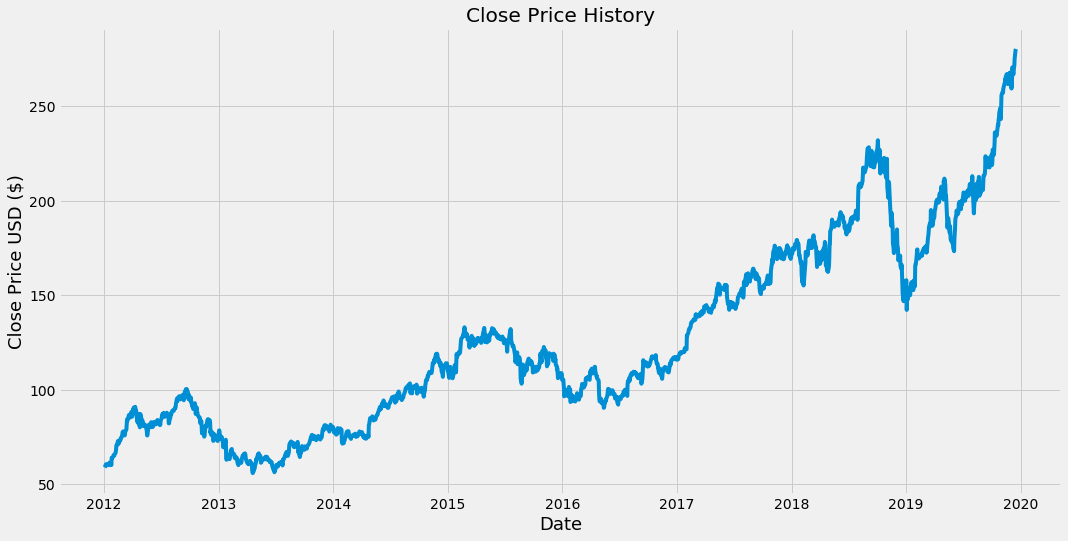

In [15]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [16]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
#That is equivalently the length that we want the training data set to have 
# and equivalently it is equal to the ending index - 1 of the training data set
training_data_len = math.ceil( len(dataset) *.8) # Length is about 80% of the original data, which is 2003 * .8 = 1603 rounded up


In [17]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [18]:
type(scaled_data),scaled_data.shape

(numpy.ndarray, (2003, 1))

In [19]:
#Create the training data set
#Create the scaled training data set :  a new array containing the scaled values from index 0 to 1602
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])#The independent training variables or training feature set 'X' (holds the stock price value for the past 60 days at position 'i-60')
    y_train.append(train_data[i,0])#The dependent training variables, or target, or training label set 'Y' (holds the stock price at the 61st day at position 'i-60')
#Convert x_train and y_train to numpy arrays so we can use them for training the LSTM model
x_train, y_train = np.array(x_train), np.array(y_train)

#A LSTM network expects the input to be 3-Dimensional in the form [samples, time steps, features]:
# samples is the number of data points (or rows/ records) we have, 
# time steps is the number of time-dependent steps that are there in a single data point (60),
# features/indicators refers to the number of variables we have for the corresponding true value in Y, since we are only using one feature 'Close',
# the number of features/indicators will be one
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [20]:
#Build the LSTM network model
model = Sequential()
#First LSTM layer, input_shape = the number of time steps (60 or x_train.shape[1]) while the last parameter is the number of features (1)
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1))) #Units=number of neurons, return_sequences is set to true since we will add more layers to the model.
model.add(LSTM(units=50, return_sequences=False)) #LSTM layer with 50 neurons, return sequence by default is False but I put it here just to show
model.add(Dense(units=25)) #Just your regular densely-connected Neural Network layer with 25 neurons
model.add(Dense(units=1)) #Just your regular densely-connected Neural Network layer with 1 neuron

In [21]:
#Compile the model
# optimizer = adam and the optimizer is used to improve upon the loss
# loss function = mean_squared_error (MSE) and loss functions are used to measure how well the model did on training
model.compile(optimizer='adam', loss='mean_squared_error')

In [22]:
#Fit / Train the model
#Batch Size: Total number of training examples present in a single batch
#Epoch:The number of iterations when an ENTIRE dataset is passed forward and backward through the neural network .
#Fit: Another word for train
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1543/1543 [==============================] - 144s 93ms/step - loss: 8.6670e-04


In [23]:
#Create the testing data set
#Create the scaled testing data set : a new array containing the scaled values from index 1543 to 2002 of the dataframe, for a total length of 460, using the past 60 days
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])#The independent testing variables or testing feature set 'X' (holds the stock price value for the past 60 days at position 'i-60')
#Convert x_test to a numpy array so we can use it to test and make predictions using the LSTM model we created
x_test = np.array(x_test)

#A LSTM network expects the input to be 3-Dimensional in the form [samples, time steps, features]:
# samples is the number of data points (or rows/ records) we have, 
# time steps is the number of time-dependent steps that are there in a single data point (60),
# features/indicators refers to the number of variables we have for the corresponding true value in Y, since we are only using one feature 'Close',
# the number of features/indicators will be one
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) #Reshaping the variable to be 3-Dimensional in the form [samples, time steps, features] for the Neural Network

In [24]:
#Getting the models predicted price values
predictions = model.predict(x_test) #Getting the models predicted price values
predictions = scaler.inverse_transform(predictions) #Undo the scaling

In [25]:
#Get the root mean squared error (rmse)
#RMSE is a good measure of how accurately the model predicts the response
#(RMSE) is the standard deviation of the residuals (prediction errors).
#Lower values of RMSE indicate better fit. 
#Usually you want to evaluate your model with other metrics as well to truly get an idea of how well your model performs.

#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean((predictions- y_test)**2))
rmse

5.837884004645535

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


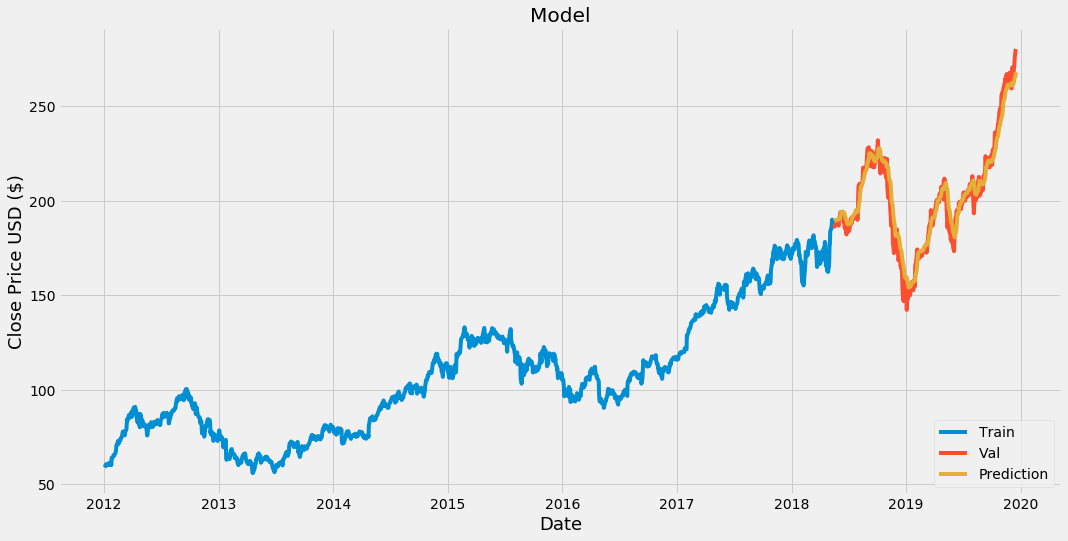

In [26]:
#Plot the data
train = data[:training_data_len] # A dataframe to get rows from index 0 to 1602 (1603 rows total)
valid = data[training_data_len:] # A dataframe to get rows from index 1603 to the end of the list 
valid['Predictions'] = predictions #Create a new column called 'Predictions' that will hold the predicted prices

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train', 'Val', 'Prediction' ], loc='lower right')
plt.show()

In [27]:
#Show the valid/actual/close prices and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,189.450806
2018-05-18,186.309998,189.612015
2018-05-21,187.630005,189.545486
2018-05-22,187.160004,189.564606
2018-05-23,188.360001,189.559296
2018-05-24,188.149994,189.708969
2018-05-25,188.580002,189.882401
2018-05-29,187.899994,190.105515
2018-05-30,187.500000,190.234100


In [28]:
#Get the quote from '2012-01-01' to '2019-12-17' to predict the closing price for '2019-12-18'
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17') 

#Create a new dataframe with only the 'Close' column
new_df = apple_quote.filter(['Close']) 
#Get the last 60 rows of data from the stock/ aka get the past 60 days of the stock and convert it to an array and store it in a variable
last_60_days = new_df[-60:].values 

#Transform the data to values between 0 and 1
last_60_days_scaled  = scaler.transform(last_60_days) 

#Create an empty list
X_test = [] 
#Append the data (the past 60 values to predict the 61st value)
X_test.append(last_60_days_scaled) 
#Convert X_test to a numpy array so we can use it to test and make predictions using the LSTM model we created
X_test = np.array(X_test) 
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)
#Get the predicted scaled price
pred_price = model.predict(X_test) 
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price) 
print(pred_price)#Print the predicted price



(1, 60, 1)
[[269.9448]]


In [29]:
#Get the actual closing price for that day
#from datetime import datetime
today = '2019 - 12-18'
#today = datetime.today().strftime('%Y-%m-%d') #Get todays date and format it in the form YYYY-MM-DD
todays_price = web.DataReader('AAPL', data_source='yahoo', start=today, end=today) #Get the stock price for today
print(todays_price['Close']) #Print the closing price of the stock for today


Date
2019-12-18    279.73999
Name: Close, dtype: float64
